Initial train image count: 1728
Initial valid image count: 439
Checking 1728 images in train for corruption...
Final train image count: 1728
Checking 439 images in valid for corruption...
Final valid image count: 439
Classes: ['closedFist', 'fingerCircle', 'fingerSymbols', 'multiFingerBend', 'openPalm', 'semiOpenFist', 'singleFingerBend', 'symbolFour', 'symbolOne', 'symbolThree', 'symbolTwo']
Number of classes: 11


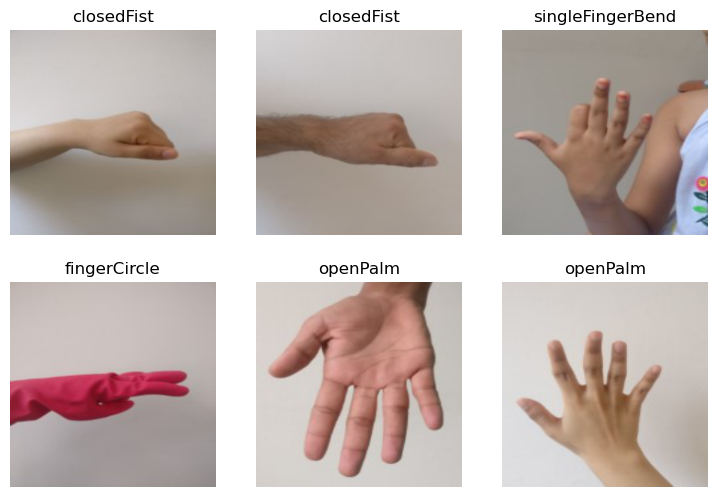

Image mode: RGB


In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from fastai.vision.all import *
from PIL import Image
from fastai.vision.utils import show_image
from torchvision.models import densenet121

# Clear any cached GPU memory
torch.cuda.empty_cache()

# Remove corrupt or non-finite images
def clean_images(img_paths):
    for img_path in img_paths:
        try:
            img = PILImage.create(img_path)
            tensor = ToTensor()(img)
            if not torch.isfinite(tensor).all():
                print(f"Bad tensor: {img_path}")
                img_path.unlink()
        except Exception as e:
            print(f"Corrupt image: {img_path}, Error: {e}")
            img_path.unlink()

# Remove corrupt or non-finite images
path = Path('data')

print("Initial train image count:", len(get_image_files(path/'train')))
print("Initial valid image count:", len(get_image_files(path/'valid')))

# Clean up images in train and valid folders
for split in ['train', 'valid']:
    imgs = get_image_files(path/split)
    print(f"Checking {len(imgs)} images in {split} for corruption...")
    clean_images(imgs)
    print(f"Final {split} image count:", len(get_image_files(path/split)))

# Create DataLoaders from folders
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=[Resize(224, method='squish')]
)
dls = dblock.dataloaders(path, bs=32)

print("Classes:", dls.vocab)
print("Number of classes:", dls.c)

# Show batch
dls.show_batch(max_n=6)
plt.show()

# Display image mode
test_img_path = 'do_rozpoznania/20250406_135604.jpg'
test_img = PILImage.create(test_img_path)
print("Image mode:", test_img.mode)

SuggestedLRs(valley=0.0010000000474974513)

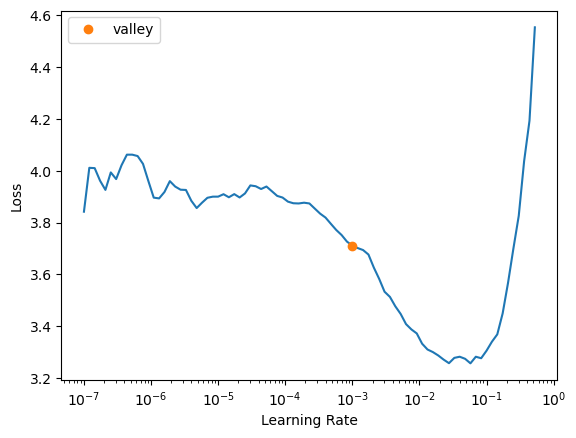

In [25]:
# Create the learner with DenseNet121
learn = vision_learner(
    dls,
    densenet121,
    metrics=error_rate,
    pretrained=True
)

# Find a good learning rate
learn.lr_find()

In [ ]:
# Phase 1: Train the head with frozen base
learn.fine_tune(
    5,
    base_lr=5e-4,
    cbs=SaveModelCallback(monitor='error_rate', fname='best-densenet')
)

# Phase 2: Unfreeze and fine-tune the whole model with discriminative learning rates
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


In [ ]:
# Use a range of learning rates for different layers
learn.fit_one_cycle(
    5,
    lr_max=slice(1e-6, 1e-4),
    cbs=SaveModelCallback(monitor='error_rate', fname='best-densenet-finetuned')
)

epoch,train_loss,valid_loss,error_rate,time
0,0.703034,1.105914,0.382688,00:19
1,0.671073,1.089884,0.382688,00:19
2,0.582856,1.055181,0.355353,00:19
3,0.505879,1.037113,0.355353,00:19
4,0.497579,1.047290,0.346241,00:19


Better model found at epoch 0 with error_rate value: 0.38268792629241943.
Better model found at epoch 2 with error_rate value: 0.35535308718681335.
Better model found at epoch 4 with error_rate value: 0.34624144434928894.


Prediction: fingerCircle
Confidence: 0.7888


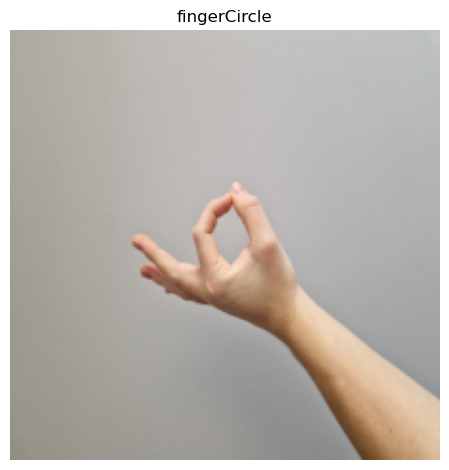

In [ ]:
# Resize the test image to match the model input size
resize = Resize(224, method='squish')
resized_img = resize(test_img)

# Predict the label for the resized image
pred_label, _, probs = learn.predict(PILImage.create(resized_img))
print(f"Prediction: {pred_label}")
print(f"Confidence: {probs.max():.4f}")

# Show predicted image with label
plt.close('all')  # Clear previous plots, esp. from lr_find()
plt.imshow(resized_img)
plt.title(pred_label)
plt.axis('off')
plt.tight_layout()
plt.show()

Prediction: semiOpenFist
Confidence: 0.7335


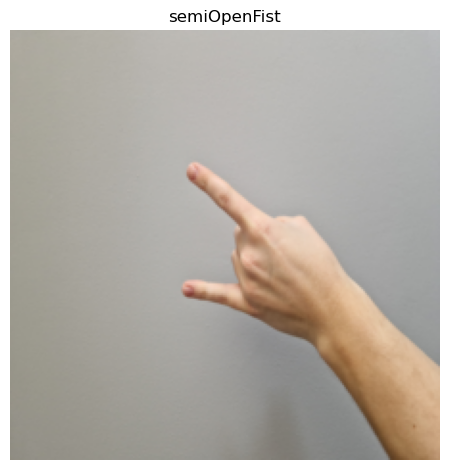

In [ ]:
test_img_path = 'do_rozpoznania/20250406_135614.jpg'
test_img = PILImage.create(test_img_path)

# Resize the predicted image to 192x192 with padding
resized_img = resize(test_img)

pred_label, _, probs = learn.predict(PILImage.create(resized_img))
print(f"Prediction: {pred_label}")
print(f"Confidence: {probs.max():.4f}")

# Show predicted image with label
plt.close('all')  # Clear previous plots, esp. from lr_find()
plt.imshow(resized_img)
plt.title(pred_label)
plt.axis('off')
plt.tight_layout()
plt.show()

Prediction: fingerSymbols
Confidence: 0.6559


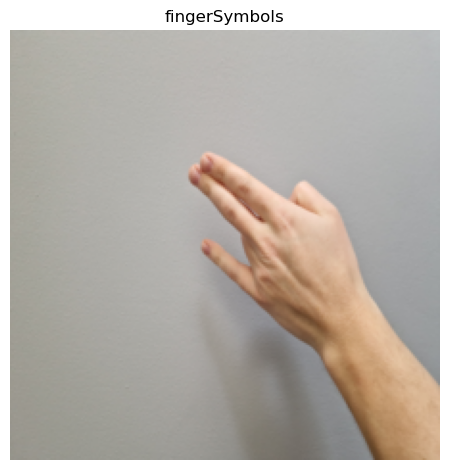

In [ ]:
test_img_path = 'do_rozpoznania/20250406_135846.jpg'
test_img = PILImage.create(test_img_path)

# Resize the predicted image to 192x192 with padding
resized_img = resize(test_img)

pred_label, _, probs = learn.predict(PILImage.create(resized_img))
print(f"Prediction: {pred_label}")
print(f"Confidence: {probs.max():.4f}")

# Show predicted image with label
plt.close('all')  # Clear previous plots, esp. from lr_find()
plt.imshow(resized_img)
plt.title(pred_label)
plt.axis('off')
plt.tight_layout()
plt.show()